In [2]:
# Description : This notebook is focused on building an artificial recurrent neural network calles LSTM 
# (Long Short Term Memory) to predict the closing price of a corporation using the past 60 days data. 

In [37]:
import math
import pandas as pd
import numpy as np
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import date
import yfinance as yf

In [122]:
today = date.today().strftime("%Y-%m-%d")
df = yf.download('AAPL','2016-01-01',today)

[*********************100%***********************]  1 of 1 completed


In [123]:
print(f"Shape : {df.shape}")
print(df.tail())
print(df.info())

Shape : (1359, 6)
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-05-19  123.160004  124.919998  122.860001  124.690002  124.690002   
2021-05-20  125.230003  127.720001  125.099998  127.309998  127.309998   
2021-05-21  127.820000  128.000000  125.209999  125.430000  125.430000   
2021-05-24  126.010002  127.940002  125.940002  127.099998  127.099998   
2021-05-25  127.820000  128.320007  126.320000  126.900002  126.900002   

              Volume  
Date                  
2021-05-19  92612000  
2021-05-20  76857100  
2021-05-21  79209300  
2021-05-24  63092900  
2021-05-25  71912400  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1359 entries, 2015-12-31 to 2021-05-25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1359 non-null   float64
 1   High       1359 non-null   float64
 2   Low        13

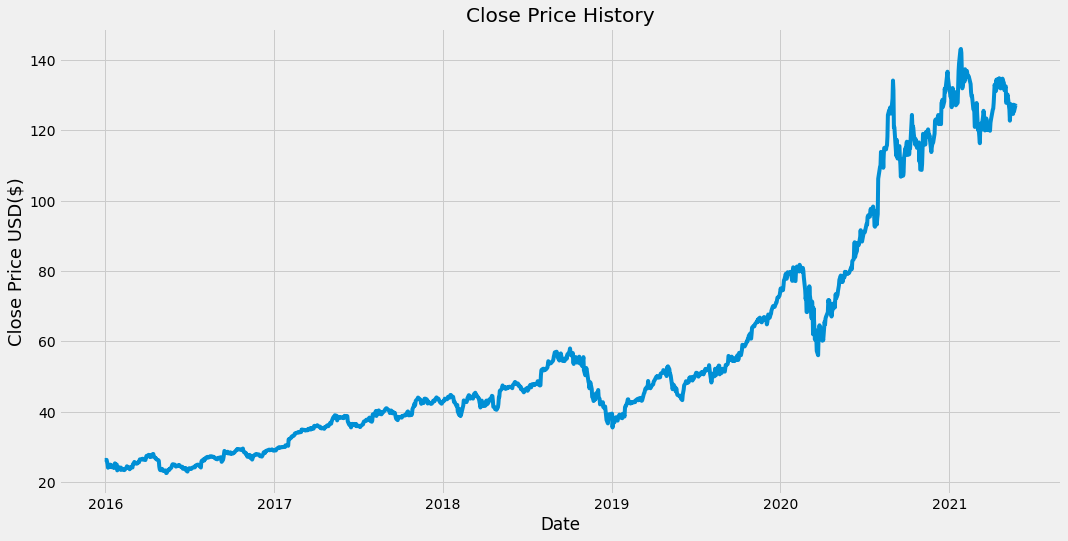

In [124]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD($)',fontsize=18)
plt.show()

In [125]:
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset) * 0.8)
training_data_len

1088

In [126]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
print(f"Raw Data : \n{dataset}")
print(f"Scaled Data : \n{scaled_data}")

Raw Data : 
[[ 26.31500053]
 [ 26.33749962]
 [ 25.67749977]
 ...
 [125.43000031]
 [127.09999847]
 [126.90000153]]
Scaled Data : 
[[0.03093511]
 [0.03112171]
 [0.02564794]
 ...
 [0.85295457]
 [0.86680486]
 [0.86514616]]


In [127]:
train_data = scaled_data[0:training_data_len,:]
x_train = []
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [128]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1028, 60, 1)

In [129]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [130]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [131]:
model.fit(x_train,y_train,batch_size=1,epochs=1)

1028/1028 [==============================] - 17s 15ms/step - loss: 0.0012


In [132]:
test_data = scaled_data[training_data_len-60:,:]
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [133]:
x_test = np.array(x_test)

In [134]:
x_test

array([[0.45266431, 0.47379225, 0.4791831 , ..., 0.39939871, 0.39981341,
        0.39029646],
       [0.47379225, 0.4791831 , 0.48697903, ..., 0.39981341, 0.39029646,
        0.40926811],
       [0.4791831 , 0.48697903, 0.47623884, ..., 0.39029646, 0.40926811,
        0.42185358],
       ...,
       [0.816131  , 0.8183703 , 0.87252745, ..., 0.84814427, 0.84681733,
        0.8685465 ],
       [0.8183703 , 0.87252745, 0.85038358, ..., 0.84681733, 0.8685465 ,
        0.85295457],
       [0.87252745, 0.85038358, 0.82500514, ..., 0.8685465 , 0.85295457,
        0.86680486]])

In [135]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [136]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [137]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

1.7916429245164034

<ipython-input-138-7aa66b8d0b79>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


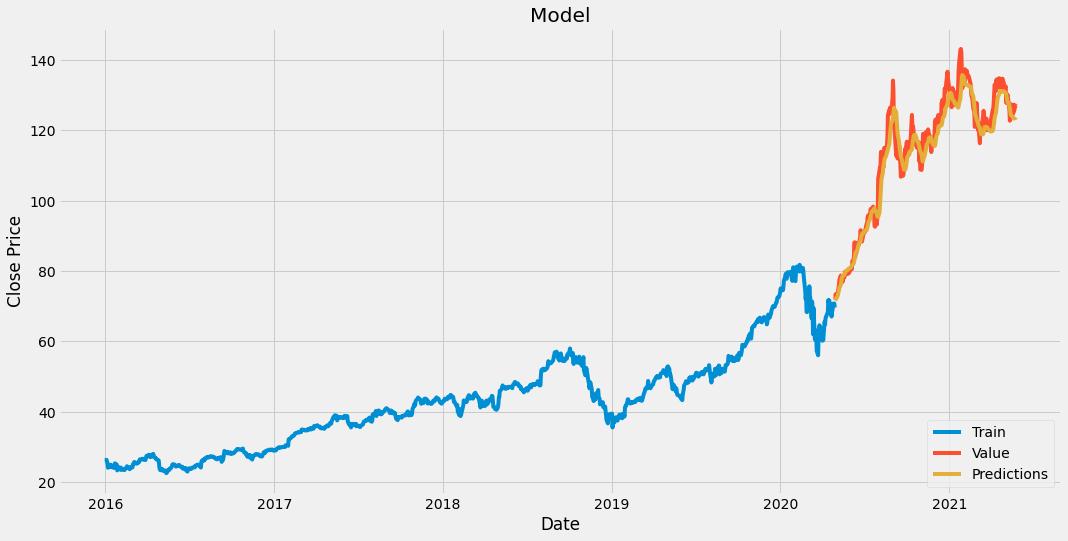

In [138]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Value','Predictions'],loc='lower right')
plt.show()

In [139]:
valid

,Close,Predictions
Date,,
2020-04-29,71.932503,71.612274
2020-04-30,73.449997,71.866310
2020-05-01,72.267502,72.364471
2020-05-04,73.290001,72.805878
2020-05-05,74.389999,73.292931
...,...,...
2021-05-19,124.690002,123.596260
2021-05-20,127.309998,123.356537
2021-05-21,125.430000,123.473122


In [140]:
apple_quote = df = yf.download('AAPL','2010-01-01','2021-05-25')
new_df = apple_quote.filter(['Close'])
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
pred_price

[*********************100%***********************]  1 of 1 completed


array([[123.71364]], dtype=float32)

In [141]:
apple_quote_2 = yf.download('AAPL','2021-05-26','2021-05-26')
apple_quote_2

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-05-25,127.82,128.320007,126.32,126.900002,126.900002,71912400


In [142]:
apple_quote

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-12-31,7.611786,7.619643,7.520000,7.526071,6.471691,352410800
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.572422,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.583784,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.479061,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.467082,477131200
...,...,...,...,...,...,...
2021-05-18,126.559998,126.989998,124.779999,124.849998,124.849998,63342900
2021-05-19,123.160004,124.919998,122.860001,124.690002,124.690002,92612000
2021-05-20,125.230003,127.720001,125.099998,127.309998,127.309998,76857100
